<a href="https://colab.research.google.com/github/mateollorente/Producto/blob/master/BuenVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from google.colab import userdata
import os, json
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models


In [2]:
!git clone https://github.com/SantiagoBuffa/BeatAI.git
%cd BeatAI

Cloning into 'BeatAI'...
remote: Enumerating objects: 884, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 884 (delta 55), reused 46 (delta 14), pack-reused 762 (from 3)
Receiving objects: 100% (884/884), 103.25 MiB | 21.32 MiB/s, done.
Resolving deltas: 100% (585/585), done.
/content/BeatAI


In [3]:


kaggle_username = userdata.get("kaggle_username")
kaggle_key = userdata.get("kaggle_key")

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip install kaggle --quiet
!kaggle datasets download -d evilspirit05/ecg-analysis -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/evilspirit05/ecg-analysis
License(s): MIT
 98% 808M/826M [00:07<00:00, 85.9MB/s]
100% 826M/826M [00:07<00:00, 120MB/s] 


In [4]:
def apply_degradation_to_gray(gray_img):
    """
    Aplica un desenfoque Gaussiano y ruido normal a una imagen
    en escala de grises (array de NumPy).
    """
    # 1. Aplicar desenfoque (blur)
    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # 2. A√±adir ruido
    # Convertimos a float32 para sumar el ruido sin problemas de clipping
    degraded_float = blurred.astype(np.float32)
    noise = np.random.normal(0, 10, gray_img.shape) # Ruido con std dev 10
    degraded_float += noise

    # 3. Volver al rango 0-255 y al tipo uint8
    degraded_clipped = np.clip(degraded_float, 0, 255)

    return degraded_clipped.astype(np.uint8)

In [36]:
def ecg_to_vector(path, num_rows=4, smooth=True, apply_degradation=False):
    """
    Tu funci√≥n de extracci√≥n de se√±al, ahora con degradaci√≥n opcional.
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    target_size = (1300, 930)
    gray = cv2.resize(gray, target_size, interpolation=cv2.INTER_AREA)
    # --- INICIO DE LA MODIFICACI√ìN ---
    # Si se activa, aplicamos la degradaci√≥n a la imagen en grises
    # ANTES de cualquier otro procesamiento.
    #if apply_degradation:
        #gray = apply_degradation_to_gray(gray)
    # --- FIN DE LA MODIFICACI√ìN ---

    # El resto de tu l√≥gica de binarizaci√≥n y limpieza funciona
    # ahora sobre la imagen 'gray' (limpia o degradada).
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 35, 10)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Manejar im√°genes vac√≠as (sin contornos)
    if len(contours) == 0:
        # Si no hay contornos, devuelve un vector de ceros
        # (o podr√≠as decidir omitir este archivo en la funci√≥n de carga)
        print(f"Advertencia: No se encontraron contornos en {path}. Saltando.")
        return None # Devolver None para que la funci√≥n de carga lo omita

    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    clean = clean[y:y+h, x:x+w]

    height = clean.shape[0]

    # Evitar divisi√≥n por cero si la imagen es muy peque√±a
    if height < num_rows:
        print(f"Advertencia: Altura de contorno ({height}) menor que num_rows en {path}. Saltando.")
        return None

    row_height = height // num_rows
    signals = []

    for i in range(num_rows):
        row = clean[i*row_height:(i+1)*row_height, :]
        ys = []
        for col in range(row.shape[1]):
            pixels = np.where(row[:, col] > 0)[0]
            if len(pixels) > 0:
                ys.append(np.mean(pixels))
            else:
                ys.append(np.nan)

        ys = np.array(ys)
        nans = np.isnan(ys)

        # Manejar caso donde todos son NaNs
        if np.all(nans) or not np.any(~nans):
            ys[:] = 0 # Rellenar con ceros si la tira est√° vac√≠a
        elif np.any(nans):
            # Interpolar NaNs
            ys[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), ys[~nans])

        # Normalizar la se√±al de la tira (evitar divisi√≥n por cero)
        min_y, max_y = np.min(ys), np.max(ys)
        if max_y - min_y > 1e-6: # Un umbral peque√±o
            ys = (ys - min_y) / (max_y - min_y)
        else:
            ys[:] = 0.5 # Si la l√≠nea es plana, ponerla en el medio

        signals.append(ys)

    vector = np.concatenate(signals)

    if smooth:
        vector = cv2.GaussianBlur(vector.reshape(-1, 1), (9, 1), 0).flatten()

    return vector

In [27]:
def resize_vector(v, target_len=2048):
    x_old = np.linspace(0, 1, len(v))
    x_new = np.linspace(0, 1, target_len)
    return np.interp(x_new, x_old, v)

In [28]:
def preprocess_dataset_1d(dataset_path, target_len=2048, num_rows=4):
    """
    Carga todas las im√°genes del dataset y genera vectores 1D concatenados.
    - Aplica degradaci√≥n al conjunto de 'train'.
    - NO aplica degradaci√≥n al conjunto de 'test'.
    """
    train_dir = os.path.join(dataset_path, 'train')
    test_dir = os.path.join(dataset_path, 'test')

    X_train, y_train = [], []
    X_test, y_test = [], []

    class_names = sorted(os.listdir(train_dir))
    print(f"üìÇ Clases detectadas: {class_names}")

    # --- TRAIN (CON DEGRADACI√ìN) ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(train_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (train)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            # Llamamos con apply_degradation=True
            vec = ecg_to_vector(path, num_rows=num_rows, apply_degradation=True)

            # Omitir si la funci√≥n devolvi√≥ None (por error o sin contornos)
            if vec is None:
                continue

            vec = resize_vector(vec, target_len)
            X_train.append(vec)
            y_train.append(label)

    # --- TEST (SIN DEGRADACI√ìN) ---
    for label, cls in enumerate(class_names):
        cls_dir = os.path.join(test_dir, cls)
        for fname in tqdm(os.listdir(cls_dir), desc=f"Procesando {cls} (test)"):
            path = os.path.join(cls_dir, fname)
            if not fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                continue

            # Llamamos con apply_degradation=False
            vec = ecg_to_vector(path, num_rows=num_rows, apply_degradation=False)

            if vec is None:
                continue

            vec = resize_vector(vec, target_len)
            X_test.append(vec)
            y_test.append(label)

    X_train = np.array(X_train)[..., np.newaxis]
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_names))
    X_test = np.array(X_test)[..., np.newaxis]
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(class_names))

    # --- SPLIT VALIDATION ---
    # X_val se crear√° a partir de X_train, por lo que tambi√©n
    # contendr√° im√°genes degradadas, lo cual es correcto.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train.argmax(axis=1)
    )

    print(f"‚úÖ X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
    return X_train, y_train, X_val, y_val, X_test, y_test

In [29]:
def build_ecg_1d_model(input_length=2048, num_classes=4):
    """
    Construye el modelo CNN 1D.
    """
    model = models.Sequential([
        # El Input debe tener la forma (longitud, canales)
        layers.Input(shape=(input_length,)),
        # Reshape para a√±adir el canal (necesario para Conv1D)
        layers.Reshape((input_length, 1)),

        layers.Conv1D(32, 7, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.MaxPooling1D(2),

        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [37]:
dataset_path = "/content/BeatAI/data/ECG_DATA"
TARGET_VECTOR_LENGTH = 2048
NUM_CLASSES = 4


X_train, y_train, X_val, y_val, X_test, y_test = preprocess_dataset_1d(
    dataset_path
)




üìÇ Clases detectadas: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (train): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 956/956 [01:23<00:00, 11.45it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (train): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 516/516 [00:45<00:00, 11.31it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (train): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 699/699 [01:01<00:00, 11.43it/s]
Procesando Normal Person ECG Images (284x12=3408) (train): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 852/852 [01:14<00:00, 11.50it/s]
Procesando ECG Images of Myocardial Infarction Patients (240x12=2880) (test): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 239/239 [00:20<00:00, 11.47it/s]
Procesando ECG Images of Patient that have History of MI (172x12=2064) (test): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 172/172 [00:14<00:00, 11.75it/s]
Procesando ECG Images of Patient that have abnormal heartbeat (233x12=2796) (test): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà|

‚úÖ X_train: (2418, 2048, 1), X_val: (605, 2048, 1), X_test: (928, 2048, 1)


In [38]:
# Construir el modelo
model = build_ecg_1d_model(
    input_length=TARGET_VECTOR_LENGTH,
    num_classes=NUM_CLASSES
)



In [47]:
model.summary()

print("\nIniciando entrenamiento...")
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)]
)

# Evaluar en el conjunto de test (limpio)
print("\nEvaluando en el conjunto de test (limpio)...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Model: "sequential_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ reshape_5 (Reshape)             ‚îÇ (None, 2048, 1)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_17 (Conv1D)              ‚îÇ (None, 2048, 32)       ‚îÇ           256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_12 (MaxPooling1D) ‚îÇ (None, 1024, 32)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_18 (Conv1D)              ‚îÇ (None, 1024, 64)       ‚îÇ        10,304 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling1d_13 (MaxPooling1D) ‚îÇ (None, 512, 64)        ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_19 (Conv1D)              ‚îÇ (None, 512, 128)       ‚îÇ        24,704 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling1d_5      ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling1D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ (None, 64)             ‚îÇ         8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout)             ‚îÇ (None, 64)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ (None, 4)              ‚îÇ           260 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 131,342 (513.06 KB)

 Trainable params: 43,780 (171.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 87,562 (342.04 KB)


Iniciando entrenamiento...
Epoch 1/100
76/76 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step - accuracy: 0.9670 - loss: 0.1042 - val_accuracy: 0.9636 - val_loss: 0.1005
Epoch 2/100
76/76 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step - accuracy: 0.9628 - loss: 0.0966 - val_accuracy: 0.9438 - val_loss: 0.1204
Epoch 3/100
76/76 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step - accuracy: 0.9680 - loss: 0.0878 - val_accuracy: 0.9124 - val_loss: 0.2171
Epoch 4/100
76/76 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step - accuracy: 0.9487 - loss: 0.1445 - val_accuracy: 0.9537 - val_loss: 0.1117
Epoch 5/100
76/76 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 17ms/step - accuracy: 0.9611 - loss: 0.1182 - val_accuracy: 0.9752 - val_loss: 0.0721
Epoch 6/100
76/76 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 15ms/step - accuracy: 0.9654 - loss: 0.0987 - val_

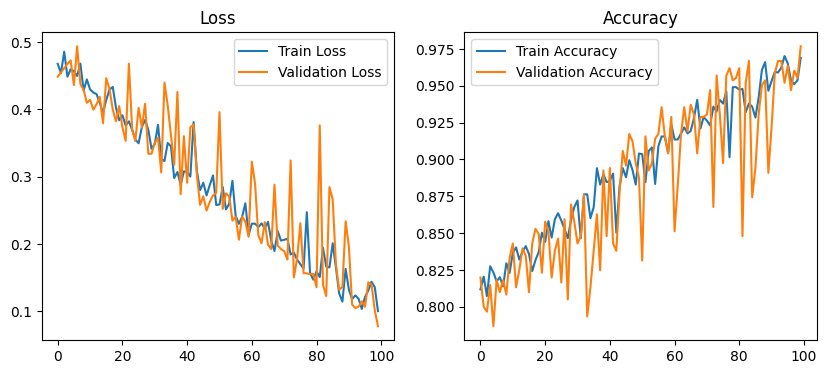

In [42]:
def show_graphs(history):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

show_graphs(history)

In [52]:
ruta_nuevo_ecg = '/content/anorm.jpeg'

# Llamamos a tu funci√≥n para obtener el vector del nuevo ECG
# Asegurate de que tu funci√≥n ecg_to_vector est√© definida o importada
try:
    vector_nuevo_ecg = ecg_to_vector(ruta_nuevo_ecg, smooth=True) # Usa los mismos par√°metros que en el entrenamiento
    vector_nuevo_ecg = resize_vector(vector_nuevo_ecg, target_len=2048)
    print(f"ECG procesado, longitud del vector: {len(vector_nuevo_ecg)}")
except Exception as e:
    print(f"Error al procesar el ECG: {e}")
    exit()

# --- PASO 3: Preparar el Vector para el model ---
# El model espera una entrada con forma (batch_size, longitud_vector, canales)
# Para una sola predicci√≥n, batch_size es 1.
vector_para_predecir = np.array([vector_nuevo_ecg]) # Poner el vector dentro de una lista para crear el batch
vector_para_predecir = vector_para_predecir.reshape(1, vector_para_predecir.shape[1], 1) # A√±adir la dimensi√≥n del canal

print(f"Forma del vector para predicci√≥n: {vector_para_predecir.shape}")

# --- PASO 4: Realizar la Predicci√≥n ---
predicciones = model.predict(vector_para_predecir)

# `predicciones` es un array con las probabilidades para cada una de las 4 clases.
# Ejemplo: [[0.1, 0.7, 0.15, 0.05]]

# --- PASO 5: Obtener la Clase Predicha ---
# Encontramos el √≠ndice de la clase con la probabilidad m√°s alta
clase_predicha_indice = np.argmax(predicciones[0])
probabilidad_maxima = np.max(predicciones[0])

print("-" * 30)
print(f"Predicci√≥n (probabilidades): {predicciones[0]}")
print(f"√çndice de Clase Predicha: {clase_predicha_indice}")
print(f"Probabilidad de la clase predicha: {probabilidad_maxima * 100:.2f}%")
print("-" * 30)

# --- (Opcional) PASO 6: Mapear el √çndice al Nombre de la Clase ---
# Si ten√©s un diccionario que mapea √≠ndices a nombres (como el 'class_map' que usamos antes):
# class_map = {0: 'Normal', 1: 'Arritmia_A', 2: 'Arritmia_B', 3: 'Ruido'} # Ejemplo
# nombre_clase_predicha = [nombre for nombre, indice in class_map.items() if indice == clase_predicha_indice][0]
# print(f"Nombre de la Clase Predicha: {nombre_clase_predicha}")

ECG procesado, longitud del vector: 2048
Forma del vector para predicci√≥n: (1, 2048, 1)
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 31ms/step
------------------------------
Predicci√≥n (probabilidades): [1.0000000e+00 2.6619672e-14 8.0002910e-25 3.4152948e-30]
√çndice de Clase Predicha: 0
Probabilidad de la clase predicha: 100.00%
------------------------------


In [49]:
model.save("models/ecg_modelVectoreLowResolution2.h5")

In [13]:
#!git push origin main